# Pubmed Model 5 - Token, Character and Positional Embedding

![Model Architecture](https://raw.githubusercontent.com/rkumar-bengaluru/data-science/main/20-Tensorflow/07-Skimlit/resources/pubmed-model-5.jpg)

## Prepare Data

In [1]:
import os
import pandas as pd

base_dir        = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
train_data_path = base_dir + 'train.txt'
val_data_path   = base_dir + 'dev.txt'

def create_data_frame(filepath):
    lines = open(filepath).readlines()
    raw_data = []
    abstracts = ''
    for line in lines:
        if line.startswith('###'):
            abstracts = ''
        elif line.startswith('\n'):
            all_abstract = abstracts.splitlines()
            total_lines = len(all_abstract) - 1
            for index,abstract in enumerate(all_abstract):
                tmp = abstract.split('\t')
                label,text = tmp[0],tmp[1]
                current = {'label' : label,
                          'text': text.lower(),
                          'line_no':index,
                          'total_lines':total_lines}
                raw_data.append(current)
        else:
            abstracts += line
            
    df = pd.DataFrame(raw_data)
    return df

In [2]:
train_df = create_data_frame(train_data_path)
val_df   = create_data_frame(val_data_path)

In [3]:
len(train_df),len(val_df)

(180040, 30212)

In [4]:
train_df.head()

,label,text,line_no,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [5]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder(sparse_output=False)
one_hot.fit(train_df['label'].to_numpy().reshape(-1,1))
train_label_one_hot = one_hot.transform(train_df['label'].to_numpy().reshape(-1,1))
val_label_one_hot   = one_hot.transform(val_df['label'].to_numpy().reshape(-1,1))

In [6]:
train_label_one_hot[0],val_label_one_hot[0]

(array([0., 0., 0., 1., 0.]), array([1., 0., 0., 0., 0.]))

## Token Embedding

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import TextVectorization, Embedding, Input,Dense,GlobalAveragePooling1D

max_tokens = 68000 # from the paper
embedding_output_dimension = 128
# find the lengths of all sentences in the sample.
sentence_lengths = [len(sentence) for sentence in train_df['text'].to_numpy()]
coverage_percentage = 95
output_sequence_length = np.percentile(sentence_lengths,coverage_percentage)
print(f'output dimension = {output_sequence_length}')

2023-06-15 07:32:57.422162: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


output dimension = 290.0


In [8]:

# token model
inputs = Input(shape=[],dtype=tf.string,name='token_model_input')
token_vectorizer = TextVectorization(max_tokens=max_tokens,
                                   output_sequence_length=int(output_sequence_length),
                                    name='token_model_token_vector')
token_embedder   = Embedding(input_dim=max_tokens,
                            output_dim=embedding_output_dimension,
                            mask_zero=True,
                            name='token_model_token_embedding')
token_vectorizer.adapt(train_df['text'].tolist())

2023-06-15 07:32:58.636763: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-15 07:32:58.640843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-15 07:32:58.641091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-15 07:32:58.642944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-15 07:32:58.643204: I tensorflow/compile

In [9]:
from tensorflow.keras.layers import Conv1D

x = token_vectorizer(inputs) # vectorize inputs
x = token_embedder(x) # embed token vectors
x = Conv1D(filters=64,
          kernel_size=5,
          padding="same",
          activation="relu",
          name="conv1d_Layer")(x)
x = GlobalAveragePooling1D(name="global_average_pooling")(x)
outputs = Dense(128,activation='relu',name='token_model_fc1')(x)
model_5_token_model = Model(inputs=inputs,
             outputs=outputs,
               name='pubmed_model_5_token_model')
model_5_token_model.summary()

Model: "pubmed_model_5_token_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_model_input (InputLay  [(None,)]                0         
 er)                                                             
                                                                 
 token_model_token_vector (T  (None, 290)              0         
 extVectorization)                                               
                                                                 
 token_model_token_embedding  (None, 290, 128)         8704000   
  (Embedding)                                                    
                                                                 
 conv1d_Layer (Conv1D)       (None, 290, 64)           41024     
                                                                 
 global_average_pooling (Glo  (None, 64)               0         
 balAveragePooling1D)                   

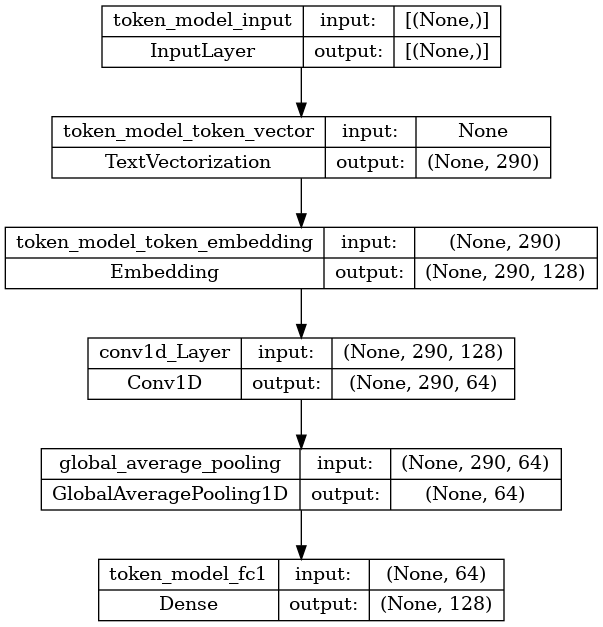

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(model_5_token_model,show_shapes=True)

## Universal Sentence Encoder

In [11]:
use = 'https://tfhub.dev/google/universal-sentence-encoder/4'

import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras import Model

use_layer = hub.KerasLayer(use,trainable=False,name='use_4')
use_inputs = Input(shape=[],dtype=tf.string,name='use_inputs')
use_embedding = use_layer(use_inputs)
dense = Dense(128,activation='relu',name='use_outputs')(use_embedding)
use_model = Model(inputs=use_inputs,
                 outputs=dense,
                 name='use_model')
use_model.summary()

Model: "use_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 use_inputs (InputLayer)     [(None,)]                 0         
                                                                 
 use_4 (KerasLayer)          (None, 512)               256797824 
                                                                 
 use_outputs (Dense)         (None, 128)               65664     
                                                                 
Total params: 256,863,488
Trainable params: 65,664
Non-trainable params: 256,797,824
_________________________________________________________________


2023-06-15 07:33:10.428751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]
2023-06-15 07:33:10.475296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


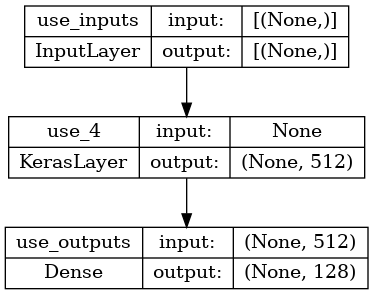

In [12]:
from tensorflow.keras.utils import plot_model

plot_model(use_model,show_shapes=True)

## Char Model

In [13]:
import string
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, TextVectorization,Bidirectional,LSTM

# prepare data for char model.
def convert_to_chars(sentence):
    return ' '.join(list(sentence))
    
train_df['chars'] = train_df.text.apply(convert_to_chars)
# character model vocabulary size
chars_vocab_size = len(string.ascii_lowercase + string.punctuation + string.digits)
char_lengths = [len(chars) for chars in train_df['text']]
total_chars_for_95_percentile_coverage = int(np.percentile(char_lengths,coverage_percentage))
# embedding_output_dimension
embedding_output_dimension = 25 # from paper
# vectorize chars
char_vectorizer = TextVectorization(max_tokens=chars_vocab_size,
                                    output_sequence_length=total_chars_for_95_percentile_coverage,
                                    name='char_model_vectorization')
char_vectorizer.adapt(train_df['chars'].tolist())
# char embedding layer
char_embedder = Embedding(input_dim=len(char_vectorizer.get_vocabulary()),
                         output_dim=embedding_output_dimension)

In [14]:
from tensorflow.keras.layers import Reshape
# char model
# input layer
model_5_chars_inputs = Input(shape=[],dtype=tf.string,name='chars_model_inputs')
x = char_vectorizer(model_5_chars_inputs)
x = char_embedder(x)
x = Bidirectional(LSTM(embedding_output_dimension))(x)

model_5_char_model = Model(inputs=model_5_chars_inputs,outputs=x)
model_5_char_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 chars_model_inputs (InputLa  [(None,)]                0         
 yer)                                                            
                                                                 
 char_model_vectorization (T  (None, 290)              0         
 extVectorization)                                               
                                                                 
 embedding (Embedding)       (None, 290, 25)           700       
                                                                 
 bidirectional (Bidirectiona  (None, 50)               10200     
 l)                                                              
                                                                 
Total params: 10,900
Trainable params: 10,900
Non-trainable params: 0
_________________________________________________________

2023-06-15 07:33:19.901303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 07:33:19.903231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 07:33:19.904497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

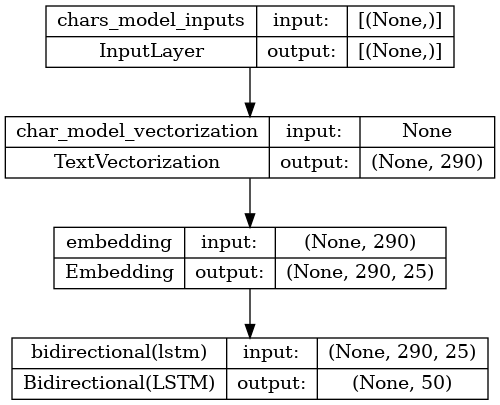

In [15]:
from tensorflow.keras.utils import plot_model

plot_model(model_5_char_model,show_shapes=True)

## Concatenate Token and Char Model

In [16]:
from tensorflow.keras.layers import Concatenate

# with universal sentence encoder
token_char_concatenate = Concatenate(name='concatenate_token_plus_char')([use_model.output,model_5_char_model.output])
token_char_concatenate
# with customer token embedding
#token_char_concatenate = Concatenate(name='concatenate_token_plus_char')([model_5_token_model.output,model_5_char_model.output])
#token_char_concatenate

<KerasTensor: shape=(None, 178) dtype=float32 (created by layer 'concatenate_token_plus_char')>

## Positional Embedding

In [17]:
train_df.head()

,label,text,line_no,total_lines,chars
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,t o i n v e s t i g a t e t h e e f f i ...
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,a t o t a l o f @ p a t i e n t s w ...
2,METHODS,outcome measures included pain reduction and i...,2,11,o u t c o m e m e a s u r e s i n c l u d ...
3,METHODS,pain was assessed using the visual analog pain...,3,11,p a i n w a s a s s e s s e d u s i n g ...
4,METHODS,secondary outcome measures included the wester...,4,11,s e c o n d a r y o u t c o m e m e a s u ...


In [18]:
line_no_depth = int(np.percentile(train_df.line_no.to_numpy(),95))
total_lines_depth = int(np.percentile(train_df.total_lines.to_numpy(),95))
line_no_depth,total_lines_depth

(13, 18)

In [19]:
import tensorflow as tf

train_lineno_onehot = tf.one_hot(train_df.line_no.to_numpy(),line_no_depth)
train_totalline_onehot = tf.one_hot(train_df.total_lines.to_numpy(),total_lines_depth)
val_lineno_onehot = tf.one_hot(val_df.line_no.to_numpy(),int(np.percentile(val_df.line_no.to_numpy(),95)))
val_totalline_onehot = tf.one_hot(val_df.total_lines.to_numpy(),int(np.percentile(val_df.total_lines.to_numpy(),95)))
train_lineno_onehot,train_totalline_onehot,val_lineno_onehot,val_totalline_onehot

(<tf.Tensor: shape=(180040, 13), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(180040, 18), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(30212, 13), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(30212, 18), dtype=flo

In [20]:
val_totalline_onehot[0]

<tf.Tensor: shape=(18,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>

In [21]:
from tensorflow.keras.layers import Dense,Input

line_inputs = Input((13,),dtype=tf.float32,name='line_no_input')
line_dense = Dense(32,activation='relu')(line_inputs)
line_model = Model(inputs=line_inputs,outputs=line_dense)
line_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 line_no_input (InputLayer)  [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 32)                448       
                                                                 
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


In [22]:
tline_inputs = Input((18,),dtype=tf.float32,name='total_lines_input')
tline_dense = Dense(32,activation='relu')(tline_inputs)
tline_model = Model(inputs=tline_inputs,outputs=tline_dense)
tline_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 total_lines_input (InputLay  [(None, 18)]             0         
 er)                                                             
                                                                 
 dense_1 (Dense)             (None, 32)                608       
                                                                 
Total params: 608
Trainable params: 608
Non-trainable params: 0
_________________________________________________________________


In [23]:
from tensorflow.keras.layers import Dropout,GlobalAveragePooling1D
from tensorflow.keras.layers import Concatenate 

combined_dense = Dense(units=256,activation='relu')(token_char_concatenate)
combined_final_dropout = Dropout(0.5)(combined_dense)
line_total_concat = Concatenate(name='line_total_concat')([line_model.output,
                                                           tline_model.output,
                                                          combined_final_dropout])

combined_output = Dense(5,activation='softmax')(line_total_concat)

model_5 = Model(inputs=[line_model.input,
                        tline_model.input,
                        use_model.input, # with universal sentence encoder
                        #model_5_token_model.input, # with customer token embedding
                        model_5_char_model.input],
               outputs=combined_output,
               name='model_5_token_and_char_embeddings')
model_5.summary()

Model: "model_5_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 chars_model_inputs (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                                                                  
 use_inputs (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 char_model_vectorization (Text  (None, 290)         0           ['chars_model_inputs[0][0]']     
 Vectorization)                                                                                   
                                                                  

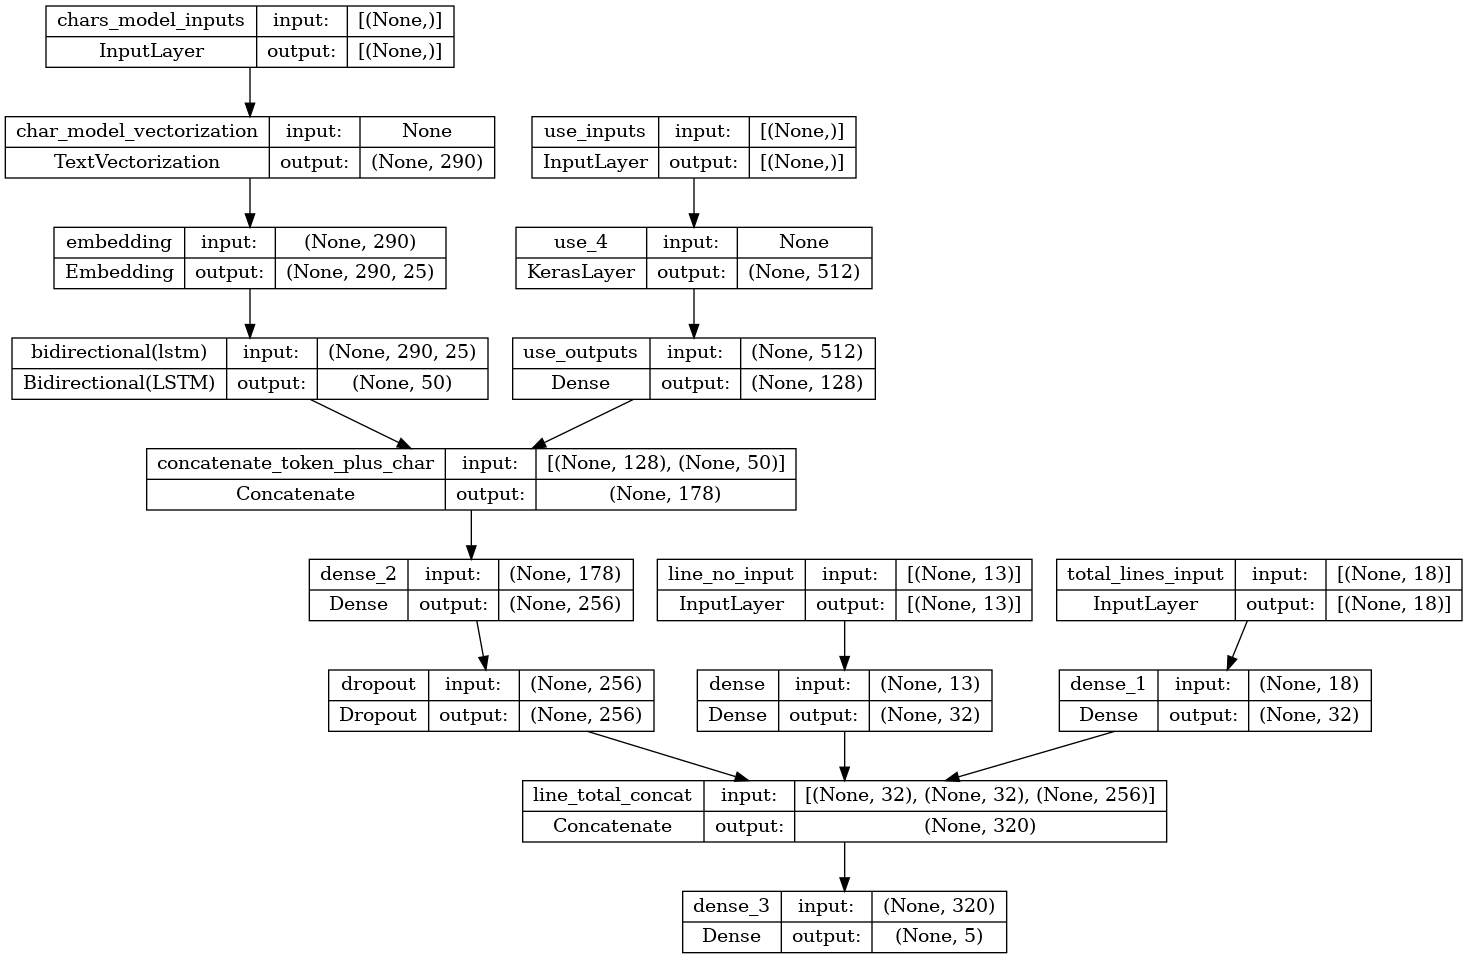

In [24]:
from tensorflow.keras.utils import plot_model

plot_model(model_5,show_shapes=True)

## Prepare Data

In [25]:
from tensorflow.data import Dataset
from sklearn.preprocessing import OneHotEncoder

train_df['chars'] = train_df.text.apply(convert_to_chars)
val_df['chars'] = val_df.text.apply(convert_to_chars)

one_hot = OneHotEncoder(sparse_output=False)
train_labels_one_hot  = one_hot.fit_transform(train_df['label'].to_numpy().reshape(-1,1))
val_labels_one_hot    = one_hot.fit_transform(val_df['label'].to_numpy().reshape(-1,1))

# train data set
train_token_char_data = Dataset.from_tensor_slices( (train_lineno_onehot,
                                                     train_totalline_onehot,
                                                     train_df['text'].tolist(),
                                                     train_df['chars'].tolist()))
train_token_char_label = Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_dataset = Dataset.zip((train_token_char_data,train_token_char_label))

# prefetch
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
print(train_token_char_dataset)

# val data set
val_token_char_data = Dataset.from_tensor_slices((val_lineno_onehot,
                                                  val_totalline_onehot,
                                                  val_df['text'].tolist(),
                                                  val_df['chars'].tolist()))
val_token_char_label = Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_dataset = Dataset.zip((val_token_char_data,val_token_char_label))

val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>


In [26]:
model_5.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
# fit the model
model_5_history = model_5.fit(train_token_char_dataset,
         steps_per_epoch=(0.1* len(train_token_char_dataset)),
         epochs=5,
         validation_data=val_token_char_dataset,
         validation_steps=(0.1*len(val_token_char_dataset)))

Epoch 1/5


2023-06-15 07:34:34.635368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [180040,13]
	 [[{{node Placeholder/_0}}]]
2023-06-15 07:34:34.849225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 07:34:34.851013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tenso

2023-06-15 07:34:36.838116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 07:34:36.839554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 07:34:36.840755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

562/562 [============================>.] - ETA: 0s - loss: 0.7856 - accuracy: 0.7081

2023-06-15 07:35:06.742253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype string and shape [30212]
	 [[{{node Placeholder/_3}}]]
2023-06-15 07:35:06.937208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 07:35:06.938392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor '

562/562 [==============================] - 35s 52ms/step - loss: 0.7852 - accuracy: 0.7081 - val_loss: 0.5816 - val_accuracy: 0.7832
Epoch 2/5
562/562 [==============================] - 28s 50ms/step - loss: 0.5140 - accuracy: 0.8052 - val_loss: 0.4788 - val_accuracy: 0.8224
Epoch 3/5
411/562 [====================>.........] - ETA: 6s - loss: 0.4760 - accuracy: 0.8142